# Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

-Был ли эксперимент успешен в целом.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

## Данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры * 1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка 


transactions_*.csv – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

## Файлы:

- users_test – информация о пользователях в тестовой группе. 
- users_control_1 – информация о пользователях в первой контрольной группе. 
- users_control_2 – информация о пользователях во второй контрольной группе. 
- transactions_test – информация о платежах пользователей в тестовой группе. 
- transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
- transactions_control_2 – информация о платежах пользователей во второй контрольной группе.

_____________________________________________________________________

# Загрузка данных

In [1]:
# Загружаем необходимые библиотеки

import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
from operator import attrgetter
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2, levene, ttest_ind, mannwhitneyu
from scipy.stats import norm
from scipy.stats import f_oneway
from statsmodels. stats.multicomp import pairwise_tukeyhsd
from tqdm.auto import tqdm

In [2]:
# Прописываем источники для загрузки данных

base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_1 = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'  
public_key_2 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'  
public_key_3 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
public_key_4 = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
public_key_5 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
public_key_6 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

# Получаем загрузочные ссылки

final_url_1    = base_url + urlencode(dict(public_key=public_key_1))
response_1     = requests.get(final_url_1)
download_url_1 = response_1.json()['href']

final_url_2    = base_url + urlencode(dict(public_key=public_key_2))
response_2     = requests.get(final_url_2)
download_url_2 = response_2.json()['href']

final_url_3    = base_url + urlencode(dict(public_key=public_key_3))
response_3     = requests.get(final_url_3)
download_url_3 = response_3.json()['href']

final_url_4    = base_url + urlencode(dict(public_key=public_key_4))
response_4     = requests.get(final_url_4)
download_url_4 = response_4.json()['href']

final_url_5    = base_url + urlencode(dict(public_key=public_key_5))
response_5     = requests.get(final_url_5)
download_url_5 = response_5.json()['href']

final_url_6    = base_url + urlencode(dict(public_key=public_key_6))
response_6     = requests.get(final_url_6)
download_url_6 = response_6.json()['href']

In [3]:
# Считываем данные для задания

users_test             = pd.read_csv(download_url_1, error_bad_lines=False, sep=';')
users_control_1        = pd.read_csv(download_url_2, error_bad_lines=False, sep=';')
users_control_2        = pd.read_csv(download_url_3, error_bad_lines=False, sep=';')
transactions_test      = pd.read_csv(download_url_4, error_bad_lines=False, sep=';')
transactions_control_1 = pd.read_csv(download_url_5, error_bad_lines=False, sep=';')
transactions_control_2 = pd.read_csv(download_url_6, error_bad_lines=False, sep=';')

___________________

 # Изучение данных / предварительная обработка

## Сперва проверим данные о пользователях платформы

In [4]:
users_test.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [5]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


Видим, что пропущенные значения есть в колонках: coins, visit_days, was_premium и is_premium.
В данных столбцах пропущенные значения мы можем заменить на нули, так как, если данных о монетах, посещении, премиуме нет, то скорее всего значения отсутствовали (были нулевые) и поэтому не были записаны в df

In [6]:
# Заменим пропуски нулями

users_test['coins']       = users_test['coins'].fillna(0)
users_test['visit_days']  = users_test['visit_days'].fillna(0)
users_test['was_premium'] = users_test['was_premium'].fillna(0)
users_test['is_premium']  = users_test['is_premium'].fillna(0)

In [7]:
# Проверим дубли в дф

users_test.uid.duplicated().sum()

0

-----------
## Теперь все тоже самое с контрольными группами

In [8]:
users_control_1.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [9]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [10]:
users_control_1['coins']       = users_control_1['coins'].fillna(0)
users_control_1['visit_days']  = users_control_1['visit_days'].fillna(0)
users_control_1['was_premium'] = users_control_1['was_premium'].fillna(0)
users_control_1['is_premium']  = users_control_1['is_premium'].fillna(0)

In [11]:
users_control_1.uid.duplicated().sum()

0

______________________________

In [12]:
users_control_2.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [13]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [14]:
users_control_2['coins']       = users_control_2['coins'].fillna(0)
users_control_2['visit_days']  = users_control_2['visit_days'].fillna(0)
users_control_2['was_premium'] = users_control_2['was_premium'].fillna(0)
users_control_2['is_premium']  = users_control_2['is_premium'].fillna(0)

In [15]:
users_control_2.uid.duplicated().sum()

0

-------------

## Теперь посмотрим на данные о транзакциях в тестовой группе

In [16]:
transactions_test.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [17]:
transactions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


Пропусков нет, зато есть некорректный тип данных в таблице. 

Необходимо привести joined_at и paid_at к формату даты

In [18]:
transactions_test["joined_at"] = pd.to_datetime(transactions_test["joined_at"])
transactions_test["paid_at"] = pd.to_datetime(transactions_test["paid_at"])

In [19]:
# Проверим написание стран, во избежание дублирования одной страны из-за разного написания 

transactions_test.country.unique()

# все в норме

array(['Italy', 'United States of America', 'Canada', 'Spain',
       'United Arab Emirates', 'Argentina', 'Latvia', 'France',
       'United Kingdom (Great Britain)', 'Israel', 'Switzerland',
       'Germany', 'Belgium', 'Chile', 'Australia', 'Mexico', 'Turkey'],
      dtype=object)

In [20]:
# Проверим дубли

transactions_test.duplicated().sum()

7

In [21]:
# Удалим дубли

transactions_test = transactions_test.drop_duplicates()

-----------
## Теперь все тоже самое с транзакциями контрольных групп

In [22]:
transactions_control_1.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [23]:
transactions_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


Наблюдаются пропуски во всех столбцах, кроме дат

  ++ у uid, payment_id и revenue вместо int64 стоит float64 - нужно исправить

In [24]:
transactions_control_1["joined_at"] = pd.to_datetime(transactions_control_1["joined_at"])
transactions_control_1["paid_at"]   = pd.to_datetime(transactions_control_1["paid_at"])

# перевод в дату также убрал лишние строки в данных

In [25]:
# Зададим uid нужный тип

transactions_control_1[['uid', 'payment_id', 'revenue']] = transactions_control_1[['uid', 'payment_id', 'revenue']] \
.values.astype('int')

# Из-за преобразования пустые значения превратились в числа, которые удалю через сброс дублей,
# а последнее удалю точечно

In [26]:
# Удалим дубли

transactions_control_1 = transactions_control_1.drop_duplicates()

In [27]:
transactions_control_1.tail(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
373,892052106,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883,147,trial_vip_popup,trial_premium
374,892145004,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919,147,trial_vip_popup,trial_premium
375,891458229,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305,19,menu,coins
376,891466989,United States of America,2017-03-11 07:08:00,2017-03-11 07:56:00,6292,147,autoreply_message,premium_no_trial
377,-9223372036854775808,NaN,NaT,NaT,-9223372036854775808,-9223372036854775808,NaN,NaN


In [28]:
# Удаляю последнюю лишнюю строчку, возникшую из-за преобразований

transactions_control_1 = transactions_control_1.drop(377)

In [29]:
# Проверим написание стран, во избежание дублирования одной страны из-за разного написания 

transactions_control_1.country.unique()

# все в норме

array(['France', 'Israel', 'Italy', 'United States of America',
       'Australia', 'Chile', 'India', 'United Arab Emirates',
       'United Kingdom (Great Britain)', 'Argentina', 'Switzerland',
       'Canada', 'Turkey', 'Portugal', 'Germany', 'Russian Federation',
       'Spain', 'Belgium'], dtype=object)

---------

In [30]:
transactions_control_2.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [31]:
transactions_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


В целом, только к дате привести и почистить дубли

In [32]:
# Переведем в дату

transactions_control_2["joined_at"] = pd.to_datetime(transactions_control_2["joined_at"])
transactions_control_2["paid_at"]   = pd.to_datetime(transactions_control_2["paid_at"])

In [33]:
# Удалим дубли

transactions_control_2 = transactions_control_2.drop_duplicates()

In [34]:
transactions_control_2

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
...,...,...,...,...,...,...,...,...
323,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium
324,891491145,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727,147,send_message,trial_premium
325,892053750,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261,19,autorefill,coins
326,891668253,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997,147,trial_vip_popup,trial_premium


In [35]:
# Проверим написание стран, во избежание дублирования одной страны из-за разного написания 

transactions_control_2.country.unique()

# все в норме

array(['Argentina', 'Chile', 'United States of America', 'Spain',
       'Switzerland', 'France', 'Italy', 'Portugal',
       'United Kingdom (Great Britain)', 'Australia', 'Belgium', 'Israel',
       'United Arab Emirates', 'Germany', 'Lithuania', 'Ukraine',
       'Canada', 'Turkey', 'Austria'], dtype=object)

------------

In [36]:
# Ну и проверим все таблицы c пользователями и транзакциями между собой
# на пересечение uid пользователей, чтобы понимать,
# что один и тот же пользователь у нас не попал в тестовую и контрольную группы

print(set(transactions_control_2.uid) & set(transactions_control_1.uid),
      set(transactions_test.uid)      & set(transactions_control_1.uid),
      set(transactions_test.uid)      & set(transactions_control_2.uid),
      set(users_control_2.uid)        & set(users_control_1.uid),
      set(users_test.uid)             & set(users_control_1.uid),
      set(users_test.uid)             & set(users_control_2.uid))

set() set() set() set() set() set()


---------------

Когда мы подробнее смотрим на данные о пользователях и их транзакциях, можно заметить что в каждом из этих дф есть данные о выручке (в users -> total_revenue, а в transactions -> revenue)

Есть предположение о том, что в дф о пользователях вынесен общий доход с пользователя за рассматриваемый период, а в данные о транзакциях вынесена информация о каждой покупке совершенной пользователем и соответствующий доход от нее.

Проверим данные по пользователям на соответствие. Возьмем из дф о пользователях только тех, кто потратил больше нуля в сервисе, а в дф-е с транзакциям сгруппируемся по пользователю и посчитаем сумму всей выручки с него.

In [37]:
display(users_test.query("total_revenue > 0").sort_values('uid')[['uid','total_revenue']].head(5), 
        transactions_test.groupby('uid', as_index=False).agg({'revenue':'sum'}).sort_values('uid').head(5))

,uid,total_revenue
3971,891071157,9100
20,891152790,12597
3967,891174411,28080
3997,891175326,897
3629,891178380,129870


,uid,revenue
0,891071157,9100
1,891152790,12597
2,891174411,28080
3,891175326,897
4,891178380,129870


На первый взгляд все сходится, но взглянем на данные чуть подробнее и попробуем вычленить пользователей у которых может не сходиться сумма всех "revenue" и строчка "total_revenue"

In [38]:
table1 = users_test.query("total_revenue > 0").sort_values('uid')[['uid','total_revenue']]

In [39]:
table2 = transactions_test.groupby('uid', as_index=False).agg({'revenue':'sum'}).sort_values('uid')

In [40]:
table3 = table1.merge(table2, on='uid')

In [41]:
table3.query('total_revenue != revenue')

,uid,total_revenue,revenue
42,891508155,10101,9165
99,892050108,16380,15119
117,892202526,2691,1794
124,892236423,95823,86996
129,892275462,14885,58968
131,892339626,17758,17004


Как видим, предположение было не верным.

У части пользователей суммы не соотносятся. Есть примеры где total_revenue больше revenue, а есть один обратный случай. Какую-то конкретику из данных получить не удается. По описанию колонок тоже не видна существенная разница рассчетов:

- revenue – нормированная выручка
- total_revenue – нормированная выручка 

Дословно: revenue - выручка от каждой транзакции, а total_revenue - сумма всей выручки от пользователя (которая также должна включать данные из колонки revenue)

Поэтому причину различий можно только предположить. Возможно это связано с тем, что в total_revenue может попадать доход платформы от перехода пользователя по рекламным баннерам. Также встречаются случаи, когда в приложении за просмотр рекламы можно получить внутреннюю валюту (в нашем случае это могут быть монеты, которые пользователи также покупают), либо дополнительные охваты профиля и тд. И понятно что такой доход от пользователя не попадет в дф с транзакциями. Ситуацию когда revenue больше total_revenue можно списать на то, что данные из транзакций не успели попасть в расчет total_revenue, и поэтому наблюдается расхождение. Ну либо произошел сбой при рассчете.

Также при дальнейшем анализе и фильтрации данных по плат. системам, странам и т.д., разница между  total_revenue и revenue будет увеличиваться, и количество пользователей тоже.

Поэтому при рассчете метрик и в А/А//А/В тестированиях в основном будут учитываться только транзакции из колонки revenue, что поможет более точечному анализу проведенных транзакций.

--------------------

In [42]:
# Посмотрим что покупают пользователи всех групп

pd.concat([transactions_test, transactions_control_1, transactions_control_2]).product_type.unique()

array(['trial_premium', 'other_type', 'premium_no_trial', 'coins'],
      dtype=object)

----------

# Отберем необходимых пользователей для анализа

По условию задачи эксперимент проводится на новых пользователях. Так как нет информации о том, является ли пользователь новым или старым, то допустим, что все пользователи в группах новые. 

Тогда проверим, чтобы даты регистрации (рамки эксперимента) совпадали у всех трех групп:

In [43]:
print('Первые регистрации:')
print('Тест      ', transactions_test.joined_at.min())
print('Контроль 1', transactions_control_1.joined_at.min())
print('Контроль 2', transactions_control_2.joined_at.min())
print('------------------------------')
print('Последние регистрации:')
print('Тест      ', transactions_test.joined_at.max())
print('Контроль 1', transactions_control_1.joined_at.max())
print('Контроль 2', transactions_control_2.joined_at.max())

Первые регистрации:
Тест       2017-01-11 03:07:00
Контроль 1 2015-01-19 11:49:00
Контроль 2 2017-01-11 08:36:00
------------------------------
Последние регистрации:
Тест       2017-10-31 23:40:00
Контроль 1 2017-10-31 22:17:00
Контроль 2 2017-10-31 17:43:00


Здесь мы видим, что первые регистрации у контрольной группы 1 на два года раньше, чем у остальных, поэтому для корректности обработки данных, я возьму только те регистрации, которые были проведены начиная с 11.01.2017.

Также нужно не забыть убрать этих пользователей еще и из дф с информацией о пользователях

In [44]:
transactions_control_1.query('joined_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type


Так как это всего лишь один пользователь, то можно просто отсечь его при фильтрации:

In [45]:
transactions_control_1 = transactions_control_1.query('uid != "960936960"')
users_control_1        = users_control_1.query('uid != "960936960"')

Теперь определимся со странами, в которых проводился эксперимент, так как по условию эксперимент затронул пользователей из нескольких конкретных стран

Создадим список стран, общий для всех групп.
Искать страны будем через дф с транзакциями, так как в дальнейшем нас будут интересовать только платящие пользователи

In [46]:
country_list = transactions_test \
                       .query('country in @transactions_control_1.country.unique() and country in @transactions_control_2.country.unique()') \
                       .country.unique()

In [47]:
country_list

array(['Italy', 'United States of America', 'Canada', 'Spain',
       'United Arab Emirates', 'Argentina', 'France',
       'United Kingdom (Great Britain)', 'Israel', 'Switzerland',
       'Germany', 'Belgium', 'Chile', 'Australia', 'Turkey'], dtype=object)

In [48]:
# Оставим данные только из нужных стран

transactions_test      = transactions_test.query('country in @country_list')
transactions_control_1 = transactions_control_1.query('country in @country_list')
transactions_control_2 = transactions_control_2.query('country in @country_list')

users_test             = users_test.query('country in @country_list')
users_control_1        = users_control_1.query('country in @country_list')
users_control_2        = users_control_2.query('country in @country_list')

In [49]:
# Посмотрим на стоимость подписки в разрезе оставшихся стран

transactions_test.query('product_type == "premium_no_trial"').sort_values('country')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
121,891605694,Argentina,2017-10-31 05:09:00,2017-11-15 04:33:00,12597,147,popular_users_block,premium_no_trial
199,891346269,Argentina,2017-05-11 12:55:00,2017-05-11 15:26:00,12597,147,autoreply_message,premium_no_trial
267,891414915,Argentina,2017-04-11 09:06:00,2017-04-11 09:56:00,6292,147,autoreply_message,premium_no_trial
95,891969984,Argentina,2017-10-23 19:59:00,2017-10-23 20:11:00,5330,147,autoreply_message,premium_no_trial
215,892347657,Argentina,2017-10-15 20:50:00,2017-10-15 22:29:00,12597,147,dating,premium_no_trial
...,...,...,...,...,...,...,...,...
27,892370097,United States of America,2017-10-15 13:37:00,2017-10-16 15:55:00,11115,68,none,premium_no_trial
22,891071157,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100,147,promo_09,premium_no_trial
6,891558921,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial
197,891603810,United States of America,2017-10-31 06:36:00,2017-04-11 09:25:00,9100,147,promo_09,premium_no_trial


Так как в рамках одной страны, одной платежной системы, одной страницы, с которой был совершен переход на оплату - стоимость подписки различна у пользователей, то будем считать, что общие для всех трех групп страны, это как раз те страны, в которых проводился эксперимент. 

Поэтому: 

country_list - это список стран, где проводился эксперимент



Теперь разберемся с платежными системами.

Так как по условию задачи "изменена стоимость премиум-подписки при покупке через две новые платежные системы", то как и в случае со странами - найдем общие платежные системы для всех трех групп, где покупалась полная премиум подписка:

In [50]:
# Идентификатор платежа = платежная система

print(transactions_test.query('product_type == "premium_no_trial"').payment_id.value_counts())
print(transactions_control_1.query('product_type == "premium_no_trial"').payment_id.value_counts())
print(transactions_control_2.query('product_type == "premium_no_trial"').payment_id.value_counts())

147    61
68     12
0       1
Name: payment_id, dtype: int64
147    85
68     16
0       2
Name: payment_id, dtype: int64
147    88
68     11
0       1
Name: payment_id, dtype: int64


Видно, что премиальныя подписка покупается только через три платежные системы.

Однако "0" использовалась только 4 раза суммарно, поэтому исключим ее.

В итоге получаем искомые две системы (68 и 147)

Оставим в дф только транзакции через них:

In [51]:
transactions_test      = transactions_test.query('payment_id == 68 or payment_id == 147')
transactions_control_1 = transactions_control_1.query('payment_id == 68 or payment_id == 147')
transactions_control_2 = transactions_control_2.query('payment_id == 68 or payment_id == 147')

И оставим в дф для дальнейшего анализа, только те транзакции, что касаются покупки премиальной подписки. Триал не учитываем, так как по условию стоимость триала не менялась

In [52]:
# Сохраним данные о пользователях до фильтрации по премиальной подписке

tt_all  = transactions_test
tc1_all = transactions_control_1
tc2_all = transactions_control_2

# Отфильтруемся

transactions_test      = transactions_test.query('product_type == "premium_no_trial"')
transactions_control_1 = transactions_control_1.query('product_type == "premium_no_trial"')
transactions_control_2 = transactions_control_2.query('product_type == "premium_no_trial"')

Не забудем про дф с пользователями. Оставим в нем только тех, кто остался в дф с транзакциями

In [53]:
ut_all  = users_test.query('uid in @tt_all.uid.unique()')
uc1_all = users_control_1.query('uid in @tc1_all.uid.unique()')
uc2_all = users_control_2.query('uid in @tc2_all.uid.unique()')

In [54]:
users_test      = users_test.query('uid in @transactions_test.uid.unique()')
users_control_1 = users_control_1.query('uid in @transactions_control_1.uid.unique()')
users_control_2 = users_control_2.query('uid in @transactions_control_2.uid.unique()')

В итоге:

- Были определены новые пользователи
- Найдены страны, в которых проводился эксперимент
- Выбраны подходящие платежные системы
- Оставлены только покупки премиальной подписки

---------------
# Первичный анализ данных

Теперь проверим данные на наличие выбросов в графах "revenue" и "total_revenue", так как для проверки успешности эксперимента будем в основном опираться на выручку с пользователя

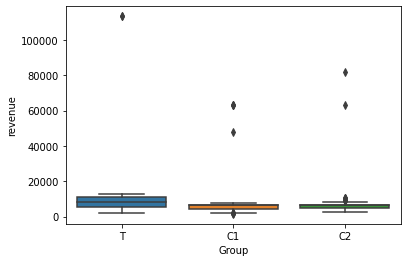

In [65]:
# Сперва добавим графу с номером группы к каждой таблице
t_T  = transactions_test.assign(Group="T", Class='Test')
t_C1 = transactions_control_1.assign(Group="C1", Class='Control')
t_C2 = transactions_control_2.assign(Group="C2", Class='Control')

# Теперь соединим данные в один df для анализа
Em_check1 = pd.concat([t_T, t_C1, t_C2])

# Построим боксплот для наглядности
sns.boxplot(x="Group", y="revenue", data=Em_check1)

Видим, что подавляющее большинство пользователей из трех групп не превышают по выручке ~40 000 у.е.

Во всех группах присутствуют высокие значения в графе "revenue"

Посмотрим на эти транзакции

In [66]:
Em_check1.query("revenue > 40000")

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,Group,Class
12,891178380,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477,147,promo_09,premium_no_trial,T,Test
196,892038759,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477,147,autoreply_message,premium_no_trial,T,Test
30,892421277,United States of America,2017-10-14 13:05:00,2017-10-15 13:11:00,47723,147,promo_09,premium_no_trial,C1,Control
143,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037,147,no_sympathy,premium_no_trial,C1,Control
277,892216461,United States of America,2017-10-18 14:41:00,2017-10-18 15:02:00,63037,147,autoreply_message,premium_no_trial,C1,Control
317,891383310,Turkey,2017-04-11 20:47:00,2017-04-11 22:17:00,63037,147,autoreply_message,premium_no_trial,C1,Control
22,892307238,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037,147,left_sidebar_menu,premium_no_trial,C2,Control
47,891778551,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796,147,left_sidebar_menu,premium_no_trial,C2,Control


Видно, что все выделяющиеся по размеру транзакции связаны с покупкой премиальной подписки. Так как в сервисах обычно предоставляется возможность оформить подписку на долгий срок (порой еще и со скидкой), то оставим эти транзакции, т.к.:
- такие транзакции есть во всех группах
- связаны они скорее всего с тем, что пользователи решили взять подписку сразу на долгий срок (1-2 года или даже больше), что также является корректным при проведении эксперимента

Посмотрим на "total_revenue"

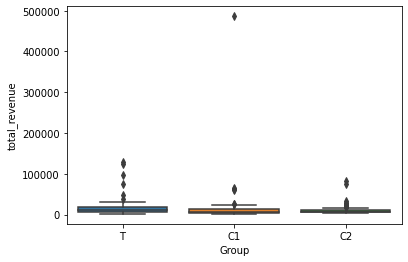

In [55]:
# Сперва добавим графу с номером группы к каждой таблице
users_T  = users_test.assign(Group="T", Class='Test')
users_C1 = users_control_1.assign(Group="C1", Class='Control')
users_C2 = users_control_2.assign(Group="C2", Class='Control')

# Теперь соединим данные в один df для анализа
Em_check = pd.concat([users_T, users_C1, users_C2])

# Построим боксплот для наглядности
sns.boxplot(x="Group", y="total_revenue", data=Em_check)

Видим, что подавляющее большинство пользователей из трех групп не превышают по выручке ~150 000 у.е.

В контрольной группе "С1" видим аномальный объем выручки ~ 500к

Проверим, что подобный выброс только в "С1" и уберем его

In [68]:
Em_check.query("total_revenue > 200000")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,Group,Class
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,C1,Control


In [69]:
# Уберем этого пользователя из дф

transactions_control_1 = transactions_control_1.query('uid != "892333905"')
users_control_1        = users_control_1.query('uid != "892333905"')
Em_check               = Em_check.query('uid != "892333905"')
tc1_all                = tc1_all.query('uid != "892333905"')
uc1_all                = uc1_all.query('uid != "892333905"')

Соединим полученные дф с данными о пользователях для дальнейшей работы

In [70]:
# Сперва добавим графу с номером группы к каждой таблице
users_t  = users_test.assign(Group="T", Class='Test')
users_c1 = users_control_1.assign(Group="C1", Class='Control')
users_c2 = users_control_2.assign(Group="C2", Class='Control')

transactions_t  = transactions_test.assign(Group="T", Class='Test')      
transactions_c1 = transactions_control_1.assign(Group="C1", Class='Control')
transactions_c2 = transactions_control_2.assign(Group="C2", Class='Control')

ut_all  = ut_all.assign(Group="T", Class='Test')
uc1_all = uc1_all.assign(Group="C1", Class='Control')
uc2_all = uc2_all.assign(Group="C2", Class='Control')

tt_all  = tt_all.assign(Group="T", Class='Test')
tc1_all = tc1_all.assign(Group="C1", Class='Control')
tc2_all = tc2_all.assign(Group="C2", Class='Control')

# Теперь соединим данные в один df для анализа
df_users            = pd.concat([users_t, users_c1, users_c2])
df_transactions     = pd.concat([transactions_t, transactions_c1, transactions_c2])
df_users_all        = pd.concat([ut_all, uc1_all, uc2_all])
df_transactions_all = pd.concat([tt_all, tc1_all, tc2_all])

---------------
## Теперь проверим репрезентативность выборок

Проверим распределение пользователей между группами, чтобы уведиться в его равномерности.

Хочется понимать - нет ли статзначимых различий между размерами групп пользователей.

Использую хи-квадрат, для выявления статистики 

- $H_0$: размеры выборок контрольных и тестовых групп статзначимо не различаются 
- $H_1$: различия в размерах выборок статзначимы

In [71]:
# Соберем данные для применения критерия

chi_2 = [[users_t.shape[0], df_users.shape[0]], 
        [users_c1.shape[0], df_users.shape[0]], 
        [users_c2.shape[0], df_users.shape[0]],]

In [72]:
stat, p, dof, expected = chi2_contingency(chi_2)

In [73]:
stat, p

(5.464285714285715, 0.06507968367867656)

Интерпретируем результат:

In [74]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [75]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Таким образом мы видим, что размеры выборок статзначимо не различаются

--------

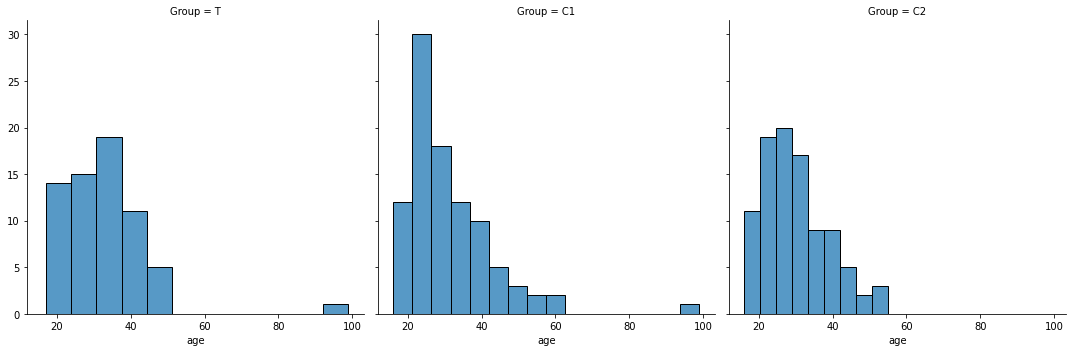

In [76]:
# Посмотрим на то, как распределены пользователи по возрасту внутри групп

g = sns.FacetGrid (data=df_users, col='Group', col_wrap= 3, height= 5)

g. map (sns.histplot , 'age') 

sns.despine()

Посмотрим на средний возраст групп:

In [77]:
print('Средние:')
print('Тест      ', df_users.query('Group == "T"').age.mean())
print('Контроль 1', df_users.query('Group == "C1"').age.mean())
print('Контроль 2', df_users.query('Group == "C2"').age.mean())

Средние:
Тест       32.784615384615385
Контроль 1 31.263157894736842
Контроль 2 29.91578947368421


Чтобы узнать статзначимы ли различия среднего возраста в группах (тестовой и контрольных), можно применить ANOVA, который поможет сравнить средние значения возраста в трех группах:

- $H_0$: Нет существенных различий по среднему возрасту между группами
- $H_1$: Есть существенные различия между группами.

In [78]:
f_oneway(df_users.query('Group == "T"').age, 
              df_users.query('Group == "C1"').age, 
              df_users.query('Group == "C2"').age)

F_onewayResult(statistic=1.3697959551560193, pvalue=0.2560445859915416)

Тест ANOVA показал, что p-значение больше 0,05, а значит мы остаемся верны нулевой гипотезе о том, что средний возраст в группах идентичен.

А значит мы можем заключить, что по возрастной разбивке группы сформированы корректно.

-------------
Теперь посмотрим на распределение внутри групп пользователей по странам:

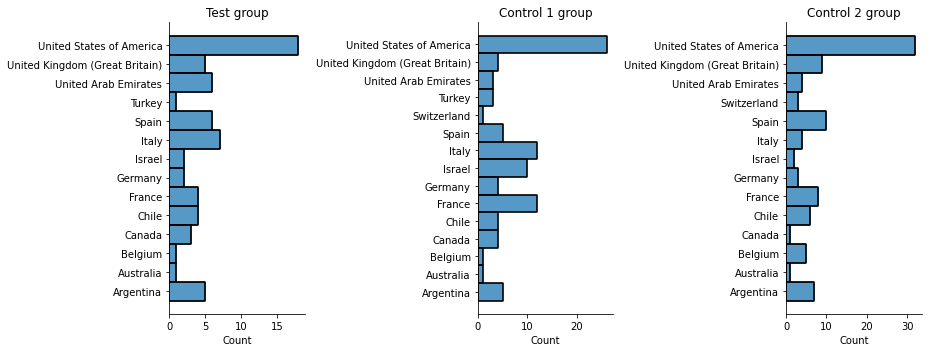

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

sns.histplot(y=users_t.country.sort_values(ascending=False), ax = axes[0])
axes[0].set(title='Test group', ylabel='')

sns.histplot(y=users_c1.country.sort_values(ascending=False), ax = axes[1])
axes[1].set(title='Сontrol 1 group', ylabel='')

sns.histplot(y=users_c2.country.sort_values(ascending=False), ax = axes[2])
axes[2].set(title='Сontrol 2 group', ylabel='')

sns.despine()
plt.tight_layout()

Сравним распределение пользователей по странам в группах с помощью статистического теста

Так как переменные Group и country - номинативные (категориальные), то для анализа нам нужно использовать хи-квадрат, перед этим обработав данные с помощью pd.crosstab

- $H_0$: Распределение по странам в группах одинаковое 
- $H_1$: Распределение по странам в группах различно

In [80]:
stat_1, p_1, dof_1, expected_1 = chi2_contingency(pd.crosstab(df_users.country, df_users.Group))

In [81]:
stat_1, p_1

(32.96066566494771, 0.2371958959361185)

Интерпретируем результат:

In [82]:
prob = 0.95
critical = chi2.ppf(prob, dof_1)
if abs(stat_1) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [83]:
rob = 0.95
alpha = 1.0 - prob
if p_1 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Таким образом мы видим, что по распределению по странам, группы статзначимо не различаются, а значит пока группы собраны репрезентативно по основным признакам

------------


Посмотрим на то, как распределены пользователи по половому признаку внутри групп

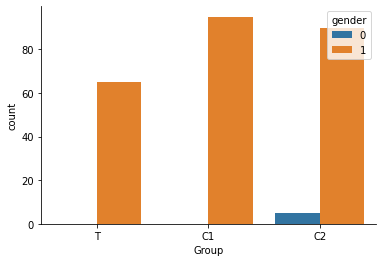

In [84]:
sns.countplot(x="Group", hue = 'gender', data=df_users)

sns.despine()

Тут в принципе не изменит сути замена чисел обозначением пола (скорее всего 1 - мужчина, 0 - женщина). 

Главное сравнить распределение полов в группах, чтобы понимать репрезентативные ли собрались выборки.

Но уже из графика видно, что по полу группы сформировались не репрезентативные, так как в тестовой и первой контрольной группах совсем нет женщин.

Ввиду такой ситуации сравним классы, вместо групп, чтобы посмотреть на ситуацию чуть шире.

Так как вновь перед взором предстают категориальные переменные, то использую хи-квадрат.

- $H_0$: Распределение по полу в классах одинаковое 
- $H_1$: Распределение по полу в классах различно

In [85]:
stat_2, p_2, dof_2, expected_2 = chi2_contingency(pd.crosstab(df_users.gender, df_users.Class))

In [86]:
stat_2, p_2

(0.6443137651821861, 0.42215302349567174)

Интерпретируем результат:

In [87]:
prob = 0.95
critical = chi2.ppf(prob, dof_2)
if abs(stat_2) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [88]:
rob = 0.95
alpha = 1.0 - prob
if p_2 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Таким образом мы видим, что по распределению по полу, классы статзначимо не различаются. 

Это интересное наблюдение, исходя из компановки групп, которая даже визуально выглядит нерепрезентативно.

В итоге можем сделать вывод, что по всем рассматриваемым признакам (кроме пола) группы сформировались репрезентативно.

----------------------

# Проверка успешности эксперимента / анализ гипотез

Так как в данном эксперименте мы смотрим в основном только на платящих пользователей, то при рассчете классической метрики ARPPU, в этом исследовании она будет подразделяться на:

- **ARPPU** - общая выручка (платящих пользователей) в среднем на одного платящего пользователя
- **ARPPU_Premium** - общая выручка (платящих пользователей) в среднем на одного платящего премиального пользователя

Для того, чтобы оценить успешность эксперимента, в первую очередь, рассмотрим изменение метрики **ARPPU_Premium**, так как эксперимент был направлен на премиальных пользователей (на изменение стоимости премиальной подписки), а значит успехом мы будем считать увеличение дохода от этих пользователей, так как это один из важных показателей эффективности бизнеса.

Также, обратим внимание на **соотношение тех кто отключил/оставил подписку**, чтобы понимать как изменение стоимости подписки повлияло на долгосрочный интерес пользователей к ней. Ведь если пользователь подключит подписку и будет ею долгое время пользоваться - это увеличит доход сервиса.

Обратим внимание на **соотношение покупок полной/триал версии подписки**, чтобы понять стала ли полная подписка привлекательней пробной. Если частота покупок полной подписки вырастет, то это сможет говорить о росте доходов сервиса, ведь, как правило, полная подписка стоит дороже. Но также если соотношение останется на прежнем уровне, то это будет значить, что премиальная подписка не стала хуже пробной, в плане цены.

Посмотрим на **конверсию в покупку подписки**, чтобы увидеть насколько успешно получается привлечь новых пользователей к пользованию подпиской

Также посмотрим и на то, как изменился средний **Total_revenue** в группах по премиальным и обычным платящим пользователям. Это даст понять стала ли в среднем площадка больше получать дохода (со всех источников) с пользователя, после внесения изменений в стоимость премиальной полной подписки. Так как методику расчета total_revenue (из-за найденных расхождений в revenue и total_revenue) мы точно не знаем, поэтому данное сравнение будет дополнительным (не основным) фактором при принятии решения об успешности эксперимента.

Ну и напоследок оценим изменение **ARPPU** по группам

Т.о. основными критериями успеха будут служить:

- Увеличение ARPPU_Premium
- Увеличение ARPPU в целом
- Премиальные пользователи не стали отключать подписку чаще
- Пользователи не стали менять свой выбор в пользу пробной подписки из-за изменения цены на полную
- Пользователи не стали меньше покупать платную подписку (конверсия не упала)

-----

### Проведем А/А тест для контрольных групп перед А/В тестированием.

Сравним группы по среднему чеку и средней общей выручке со всех платящих пользователей, а затем только премиальных.

Для начала посмотрим на средний чек всех пользователей.

Но сперва проверим различны ли дисперсии в контрольных группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [89]:
levene(tc1_all.revenue, tc2_all.revenue)

LeveneResult(statistic=0.13306394670217064, pvalue=0.7155201497960955)

Так как дисперсии не отличаются, то подставим соответствующее значение "equal_var" в тесте.

Проведем t-тест, который поможет сравнить средние значения revenue двух выборок:

- $H_0$: статистически значимых различий между средними значениями revenue в контрольных группах нет
- $H_1$: статистически значимые различия между средними значениями revenue в контрольных группах есть

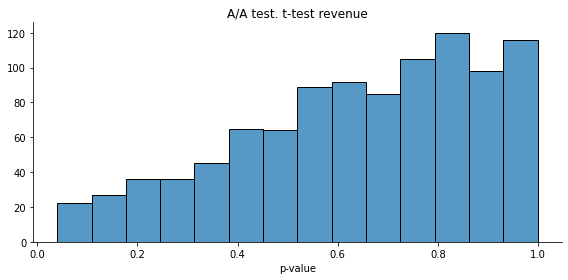

In [90]:
data = []

for i in range(1000):
    c1 = tc1_all.revenue.sample(100, replace=False).values
    c2 = tc2_all.revenue.sample(100, replace=False).values
    data.append(ttest_ind(c1, c2, equal_var = True)[1])

fig, axes = plt.subplots(figsize=(8, 4))
sns.histplot(data)
axes.set(title = 'A/A test. t-test revenue', xlabel = 'p-value', ylabel = '')
sns.despine()
plt.tight_layout()

Проверяем, что количество ложноположительных случаев не превышает уровень значимости в 0,05:

In [91]:
((np.array(data) < 0.05) / 1000).sum() < 0.05

True

Так как количество ложноположительных случаев не превышает уровень значимости, то нулевую гипотезу мы не отвергаем, а значит - статистически значимых различий между средними значениями revenue в контрольных группах не наблюдается.

Посмотрим на среднюю общую выручку со всех платящих пользователей.

Но сперва проверим различны ли дисперсии в контрольных группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [92]:
levene(uc1_all.total_revenue, uc2_all.total_revenue)

LeveneResult(statistic=0.013076504900388294, pvalue=0.909033079510561)

Так как дисперсии не отличаются, то подставим соответствующее значение "equal_var" в тесте.

Проведем t-тест, который поможет сравнить средние значения total_revenue двух выборок:

- $H_0$: статистически значимых различий между средними значениями total_revenue в контрольных группах нет
- $H_1$: статистически значимые различия между средними значениями total_revenue в контрольных группах есть

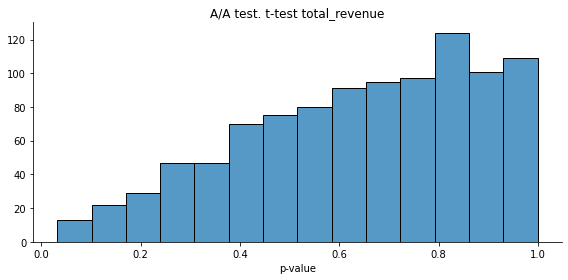

In [93]:
data_t = []

for i in range(1000):
    uc1 = uc1_all.total_revenue.sample(100, replace=False).values
    uc2 = uc2_all.total_revenue.sample(100, replace=False).values
    data_t.append(ttest_ind(uc1, uc2, equal_var = True)[1])

fig, axes = plt.subplots(figsize=(8, 4))
sns.histplot(data_t)
axes.set(title = 'A/A test. t-test total_revenue', xlabel = 'p-value', ylabel = '')
sns.despine()
plt.tight_layout()

In [94]:
((np.array(data_t) < 0.05) / 1000).sum() < 0.05

True

Так как количество ложноположительных случаев не превышает уровень значимости, то нулевую гипотезу мы не отвергаем, а значит - статистически значимых различий между средними значениями total_revenue в контрольных группах не наблюдается.

---------

Теперь посмотрим на средний чек премиальных пользователей в контрольных группах

Проверим различны ли дисперсии в контрольных группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [95]:
levene(transactions_c1.revenue, transactions_c2.revenue)

LeveneResult(statistic=0.05104185785269583, pvalue=0.8214944006972532)

Так как дисперсии не отличаются, то проведем стандартный Т-тест ("equal_var" = True).

Проведем t-тест, который поможет сравнить средние значения revenue двух выборок:

- $H_0$: статистически значимых различий между средними значениями revenue в контрольных группах нет
- $H_1$: статистически значимые различия между средними значениями revenue в контрольных группах есть

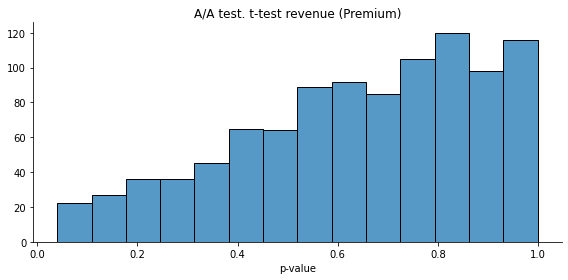

In [96]:
data_1 = []

for i in range(1000):
    c_u_1 = transactions_c1.revenue.sample(100, replace=False).values
    c_u_2 = transactions_c2.revenue.sample(99, replace=False).values
#   Сэмпл размером 99 взят потому, что в с2 количество наблюдений равняется 99 (на 1 отличается от с1)
#   Так как replace=False, то при 100 сэмплах тест не работает
#   Разницу p-value при одинаковых сэмплах и различных (на 1 единицу) не увидел, поэтому оставил так
#   Если при полномасштабном тесте это критично, то готов прочитать верное решение в сложившейся ситуации :)
    data_1.append(ttest_ind(c_u_1, c_u_2, equal_var = True)[1])

fig, axes = plt.subplots(figsize=(8, 4))
sns.histplot(data)
axes.set(title = 'A/A test. t-test revenue (Premium)', xlabel = 'p-value', ylabel = '')
sns.despine()
plt.tight_layout()

In [97]:
((np.array(data_1) < 0.05) / 1000).sum() < 0.05

True

Так как количество ложноположительных случаев не превышает уровень значимости, то нулевую гипотезу мы не отвергаем, а значит - статистически значимых различий между средними чеками премиков в контрольных группах не наблюдается.

Посмотрим на среднюю общую выручку со всех платящих премиальных пользователей.

Но сперва проверим различны ли дисперсии в контрольных группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [98]:
levene(users_c1.total_revenue, users_c2.total_revenue)

LeveneResult(statistic=0.7275507068924257, pvalue=0.39476364396290653)

Так как дисперсии не отличаются, то подставим соответствующее значение "equal_var" в тесте.

Проведем t-тест, который поможет сравнить средние значения total_revenue двух выборок:

- $H_0$: статистически значимых различий между средними значениями total_revenue в контрольных группах нет
- $H_1$: статистически значимые различия между средними значениями total_revenue в контрольных группах есть

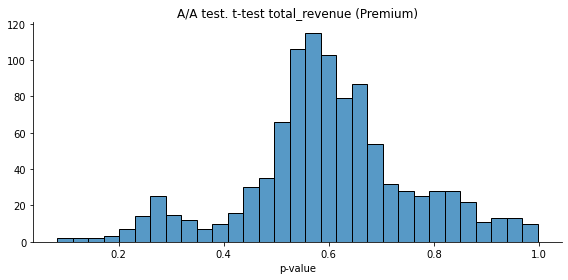

In [99]:
data_p = []

for i in range(1000):
    ucp1 = users_c1.total_revenue.sample(90, replace=False).values
    ucp2 = users_c2.total_revenue.sample(90, replace=False).values
    data_p.append(ttest_ind(ucp1, ucp2, equal_var = True)[1])

fig, axes = plt.subplots(figsize=(8, 4))
sns.histplot(data_p)
axes.set(title = 'A/A test. t-test total_revenue (Premium)', xlabel = 'p-value', ylabel = '')
sns.despine()
plt.tight_layout()

In [100]:
((np.array(data_p) < 0.05) / 1000).sum() < 0.05

True

Так как количество ложноположительных случаев не превышает уровень значимости, то нулевую гипотезу мы не отвергаем, а значит - статистически значимых различий между средними значениями total_revenue в контрольных группах не наблюдается.

Значит при проведении последующих А/В тестов, можно использовать только одну из контрольных групп. 

Я возьму контрольную группу 1, т.к. она соотносится с тестовой по отсутствию женщин.

-------------

## А/В тестирование

Cравним средний чек премиальных пользователей при подключении только премиальной подписки.

Для этого рассмотрим дф с транзакциями покупок подписки в тестовой и первой контрольной группе

In [101]:
df_ab = pd.concat([transactions_t, transactions_c1])

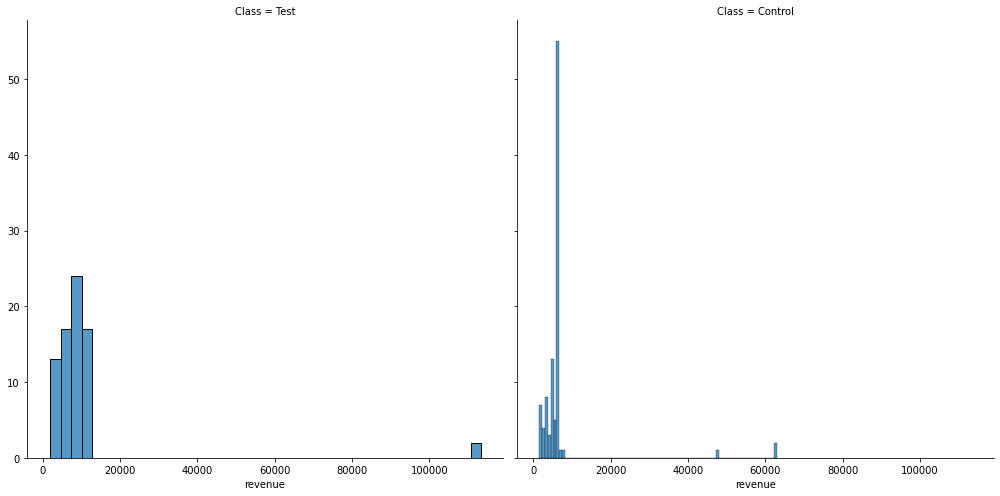

In [102]:
# Посмотрим на то, как распределены пользователи по revenue

g = sns.FacetGrid (data=df_ab, col='Class', col_wrap= 2, height= 7)

g. map (sns.histplot , 'revenue') 

sns.despine()

Чтобы узнать статзначимы ли различия среднего чека в двух группах (тестовой и контрольной), можно применить t-тест, однако перед этим нужно понимать различны ли дисперсии в группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [103]:
levene(transactions_c1.revenue, transactions_t.revenue)

LeveneResult(statistic=2.064878491293033, pvalue=0.1525541209974978)

Так как дисперсии статзначимо не отличаются (остаемся верны нулевой гиптезе), то применим стандартный Т-тест

- $H_0$: статистически значимых различий между средними значениями revenue в группах нет
- $H_1$: статистически значимые различия между средними значениями revenue в группах есть

In [104]:
ttest_ind(transactions_t.revenue, transactions_c1.revenue, equal_var=True)

Ttest_indResult(statistic=1.900837907023997, pvalue=0.059005475008388215)

Так как pvalue больше 0.05, мы остаемся верны нулевой гипотезе и можем говорить о том, что средняя выручка от продажи премиальной подписки статзначимо не выросла.

Посмотрим на абсолютные значения revenue в рассматриваемых группах:

In [105]:
transactions_t.revenue.describe()

count        73.000000
mean      10807.095890
std       17648.107012
min        1898.000000
25%        5408.000000
50%        8086.000000
75%       11115.000000
max      113477.000000
Name: revenue, dtype: float64

In [106]:
transactions_c1.revenue.describe()

count      100.000000
mean      6875.960000
std       9231.488468
min       1508.000000
25%       4537.000000
50%       6292.000000
75%       6292.000000
max      63037.000000
Name: revenue, dtype: float64

Так как в тестовой группе меньше пользователей, а средняя выручка выше чем в контрольной, то можно предположить, что в нашем эксперименте для пользователей попробовали увеличить стоимость премиальной подписки и посмотреть, что из этого выйдет.

-------

Рассчитаем средний чек всех пользователей (платящих) в обеих группах

In [107]:
df_ab_ARPU = pd.concat([tt_all, tc1_all])

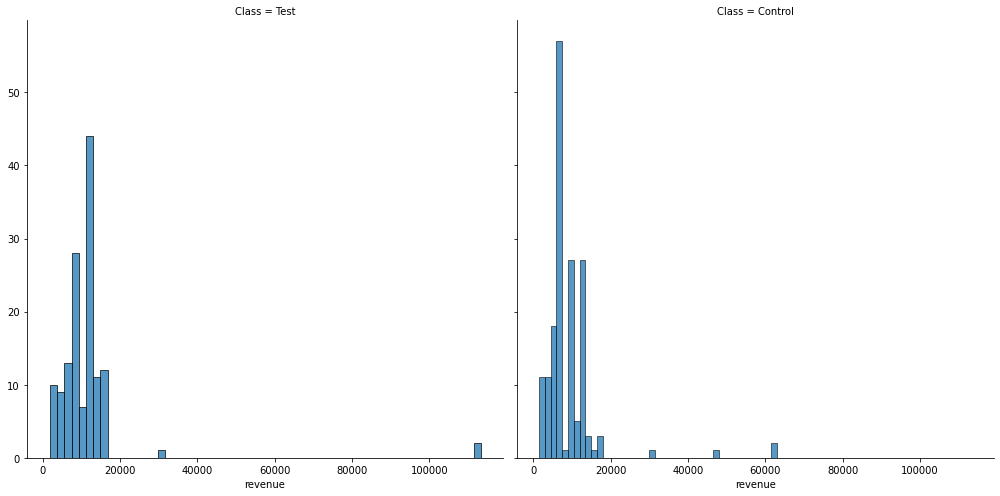

In [108]:
# Посмотрим на то, как распределены пользователи по total revenue

g = sns.FacetGrid (data=df_ab_ARPU, col='Class', col_wrap= 2, height= 7)

g. map (sns.histplot , 'revenue') 

sns.despine()

Чтобы узнать статзначимы ли различия среднего чека в двух группах (тестовой и контрольной), можно применить t-тест, однако перед этим нужно понимать различны ли дисперсии в группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [109]:
levene(tt_all.revenue, tc1_all.revenue)

LeveneResult(statistic=0.8356669062324614, pvalue=0.36136584298636887)

Так как дисперсии статзначимо не отличаются (остаемся верны нулевой гиптезе), то применим стандартный Т-тест

- $H_0$: статистически значимых различий между средними чеками в группах нет
- $H_1$: статистически значимые различия между средними чеками в группах есть

In [110]:
ttest_ind(tt_all.revenue, tc1_all.revenue, equal_var=True)

Ttest_indResult(statistic=2.520994574531958, pvalue=0.012215451734437046)

Так как pvalue меньше 0.05, мы отвергаем нулевую гипотезу и можем говорить о том, что средний чек пользователей в тестовой группе статзначимо изменился.

Взглянем на то, в какую сторону он изменился:

In [111]:
tt_all.revenue.describe()

count       137.000000
mean      11928.970803
std       13082.861293
min        1898.000000
25%        7904.000000
50%       12454.000000
75%       12766.000000
max      113477.000000
Name: revenue, dtype: float64

In [112]:
tc1_all.revenue.describe()

count      168.000000
mean      8882.791667
std       7779.202419
min       1508.000000
25%       6292.000000
50%       6376.500000
75%      10526.750000
max      63037.000000
Name: revenue, dtype: float64

Так как и средняя и медиана в тестовой группе выше, то из этого мы понимаем, что пользователи тестовой группы приносят платформе в среднем больше дохода, чем в контрольной

-------

Теперь взглянем на то, стали ли пользователи чаще отключать подписку из-за ее возросшей стоимости

- $H_0$: пользователи отключают подписку так же как и раньше, т.е. отваливаться чаще они не стали
- $H_1$: пользователи стали чаще отключать подписку по новой цене

In [113]:
# для начала из общего дф возьмем необходимые данные
df_users_1 = df_users[['uid', 'was_premium', 'is_premium', 'Group']].query('Group != "C2"')

In [114]:
# разделим клиентов на три категории: нет подписки, отключил, не отключил

def f(s):
    if s['was_premium'] == 0.0 and s['is_premium'] == 0.0:
        x = 'no_sub'
    elif s['was_premium'] == 1.0 and s['is_premium'] == 0.0:
        x = 'canceled'
    else:
        x = 'not canceled'
    return x

df_users_1['Premium'] = df_users_1.apply(f, axis = 1)

In [115]:
# взглянем на распределение пользователей

pd.crosstab(df_users_1.Group, df_users_1.Premium)

Premium,canceled,not canceled
Group,,
C1,12,83
T,7,58


Пользователей без подписки в нашем дф нет, что правильно

Так как мы имеем дело с категориями и группами клиентов, то для рассчета статистики используем хи-квадрат

- $H_0$: Распределение по категориям аналогичное
- $H_1$: Распределение по категориям значимо отличается

In [116]:
stat5, p5, dof5, expected5 = chi2_contingency(pd.crosstab(df_users_1.Group, df_users_1.Premium))
stat5, p5

(0.0118480368377227, 0.9133225059176844)

In [117]:
prob = 0.95
critical = chi2.ppf(prob, dof5)
if abs(stat5) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [118]:
prob = 0.95
alpha = 1.0 - prob
if p5 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Из-за высокого pvalue мы остаемся с нулевой гипотезой, а значит что увеличение стоимости подписки не повлекло за собой более частое отключение подписки, оттока в этом плане нет

----------------------------

Посмотрим и на то, повлияло ли изменение стоимости полной версии подписки на привлекательность пробной версии. Для этого посмотрим на то, какую подписку пользователь выбирал первой при покупке: полную или пробную

- $H_0$: возросшая стоимость подписки не повлияла на выбор пользователя между пробной и полной подпиской
- $H_1$: из-за изменения стоимости полной версии подписки, выбор пользователя изменился

In [119]:
# из общего дф возьмем необходимые данные, убрав лишние транзакции

df_transactions_all_1 = df_transactions_all.query('product_type != "other_type" and Group != "C2"')

In [120]:
# Отфильтруем дф по дате транзакции (от самых первых до последних)
df_transactions_all_1 = df_transactions_all_1.sort_values('paid_at')

In [121]:
# Теперь удалим все дуликаты по uid и оставим только первый, 
# тем самым получим только первую покупку пользователем подписки
df_transactions_all_1 = df_transactions_all_1.drop_duplicates(subset = 'uid', keep='first')

In [122]:
df_transactions_all_1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,Group,Class
374,892145004,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919,147,trial_vip_popup,trial_premium,C1,Control
254,891908385,Argentina,2017-10-25 02:33:00,2017-01-11 04:34:00,10686,147,trial_vip_popup,trial_premium,C1,Control
372,891556971,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886,68,none,premium_no_trial,C1,Control
362,891543996,United States of America,2017-01-11 13:42:00,2017-01-11 14:41:00,6292,147,user_profile,premium_no_trial,C1,Control
87,891881343,United States of America,2017-10-25 17:58:00,2017-01-11 21:08:00,12727,147,dating,trial_premium,C1,Control


Таким образом мы получили список пользователей из тестовой и контрольной групп, с информацией об их первой покупке премиальной подписки (полной или пробной) и теперь мы можем сравнить, какую версию подписки пользователи предпочитали покупать первой.

In [123]:
# взглянем на распределение пользователей

pd.crosstab(df_transactions_all_1.Group, df_transactions_all_1.product_type)

product_type,premium_no_trial,trial_premium
Group,,
C1,95,66
T,65,60


Так как мы имеем дело с категориями и группами клиентов, то для рассчета статистики используем хи-квадрат

- $H_0$: Распределение по первой покупке пробной и полной подписки аналогичное
- $H_1$: Распределение по первой покупке пробной и полной подписки значимо отличается

In [124]:
stat6, p6, dof6, expected6 = chi2_contingency(pd.crosstab(df_transactions_all_1.Group, df_transactions_all_1.product_type))
stat6, p6

(1.131599758454108, 0.28743436463136196)

In [125]:
prob = 0.95
critical = chi2.ppf(prob, dof6)
if abs(stat6) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [126]:
prob = 0.95
alpha = 1.0 - prob
if p6 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


По итогу можно говорить о том, что изменение стоимости подписки не привело к тому, что пользователи, когда выбирают какую подписку приобрести первой, стали реже подключать полную версию подписки, предпочитая ей пробную

-----------------

## Сравнение Total_revenue

Проверим разность среднего total_revenue в обоих группах. 

Благодаря этому мы можем сравнить средний общий доход от пользователя (от покупок монет, подписок и прочего) в двух группах среди платящих премиум пользователей и платящих пользователей в целом.

Для этого сперва рассмотрим дф с общей выручкой на платящего премиум пользователя в тестовой и первой контрольной группе

In [127]:
df_tr_pr = pd.concat([users_c1, users_t])

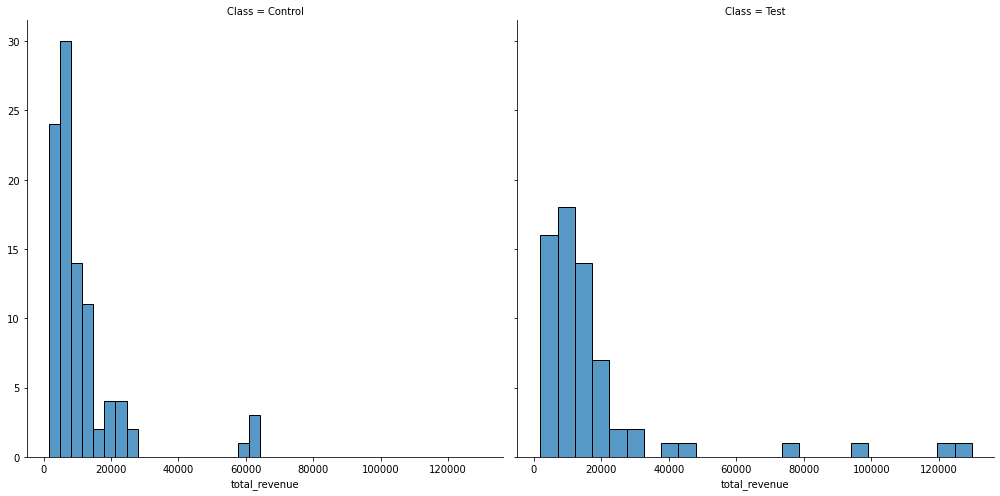

In [128]:
# Посмотрим на то, как распределены пользователи по total revenue

g = sns.FacetGrid (data=df_tr_pr, col='Class', col_wrap= 2, height= 7)

g. map (sns.histplot , 'total_revenue') 

sns.despine()

Чтобы узнать статзначимы ли различия среднего total_revenue в двух группах (тестовой и контрольной), можно применить t-тест, однако перед этим нужно понимать различны ли дисперсии в группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [129]:
levene(users_c1.total_revenue, users_t.total_revenue)

LeveneResult(statistic=3.2726870498626783, pvalue=0.07234321841189531)

Так как дисперсии статзначимо не отличаются (остаемся верны нулевой гиптезе), то применим стандартный Т-тест

- $H_0$: статистически значимых различий между средним total_revenue в группах нет
- $H_1$: статистически значимые различия между средним total_revenue в группах есть

In [130]:
ttest_ind(users_c1.total_revenue, users_t.total_revenue, equal_var=True)

Ttest_indResult(statistic=-2.404044566855862, pvalue=0.017372391929522526)

Так как pvalue меньше 0.05, мы отвергаем нулевую гипотезу и можем говорить о том, что total_revenue платящих премиум пользователей в тестовой группе статзначимо изменился.

Взглянем на то, в какую сторону он изменился:

In [131]:
print(users_t.total_revenue.mean() - users_c1.total_revenue.mean())

7107.221052631579


Так как и средний total_revenue в тестовой группе выше на 7107 у.е., то из этого мы понимаем, что платящие премиум пользователи тестовой группы приносят платформе в среднем больше общей выручки, чем в контрольной.

--------

Теперь рассмотрим дф с общей выручкой на платящего пользователя в тестовой и первой контрольной группе

In [132]:
df_tr = pd.concat([ut_all, uc1_all])

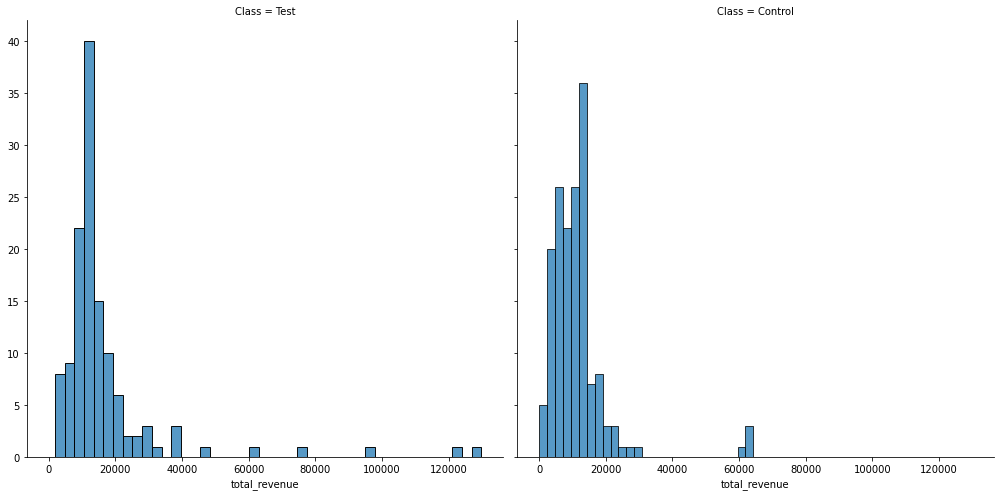

In [133]:
# Посмотрим на то, как распределены пользователи по total revenue

g = sns.FacetGrid (data=df_tr, col='Class', col_wrap= 2, height= 7)

g. map (sns.histplot , 'total_revenue') 

sns.despine()

Чтобы узнать статзначимы ли различия среднего total_revenue в двух группах (тестовой и контрольной), можно применить t-тест, однако перед этим нужно понимать различны ли дисперсии в группах, поэтому проведем тест Левена:

- $H_0$: дисперсии не отличаются (equal_var=True)
- $H_1$: дисперсии различны (equal_var=False)

In [134]:
levene(ut_all.total_revenue, uc1_all.total_revenue)

LeveneResult(statistic=3.0179143789411764, pvalue=0.08341840317428911)

Так как дисперсии статзначимо не отличаются (остаемся верны нулевой гиптезе), то применим стандартный Т-тест

- $H_0$: статистически значимых различий между средним total_revenue в группах нет
- $H_1$: статистически значимые различия между средним total_revenue в группах есть

In [135]:
ttest_ind(ut_all.total_revenue, uc1_all.total_revenue, equal_var=True)

Ttest_indResult(statistic=3.281098476405247, pvalue=0.0011612553802745587)

Так как pvalue меньше 0.05, мы отвергаем нулевую гипотезу и можем говорить о том, что total_revenue платящих пользователей в тестовой группе статзначимо изменился.

Взглянем на то, в какую сторону он изменился:

In [136]:
print(ut_all.total_revenue.mean() - uc1_all.total_revenue.mean())

5546.849620791265


Так как и средний total_revenue в тестовой группе выше на 5546 у.е., то из этого мы понимаем, что платящие пользователи тестовой группы приносят платформе в среднем больше общей выручки, чем в контрольной.

В итоге мы получили, что:

- хоть средний чек при покупке премиальной подписки статзначимо не вырос, но платформа начала получать с премиальных пользователей в среднем больше общей выручки

- также и в разрезе всех пользователей средняя общая выручка с пользователя выросла статистически значимо

---------------

### Рассчитаем метрики для групп 

Отобразим наглядно число пользователей в группе, премиальных пользователей, число юзеров без премиума (для статистического теста конверсии), непосредственно конверсию в покупку премиальной подписки, ARPPU, ARPPU_Premium:

In [137]:
test = []

Users         = ut_all.uid.nunique()
Premium_users = users_test.uid.nunique()
No_pr_user    = Users - Premium_users
Revenue       = tt_all.revenue.sum()
Сonversion    = (Premium_users/Users)
ARPPU         = (Revenue/Users)
ARPPU_Premium = (Revenue/Premium_users)

test.append(pd.DataFrame(index = ['Test'], data = {'Users':Users, 'Premium_users':Premium_users, 'No_premium': No_pr_user, 
                                                      'Сonversion':Сonversion, 'ARPPU':ARPPU, 'ARPPU_Premium':ARPPU_Premium}))
test = pd.concat(test)
test[['Сonversion','ARPPU', 'ARPPU_Premium']] = test[['Сonversion','ARPPU', 'ARPPU_Premium']].round(2)


control_1 = []

Users         = uc1_all.uid.nunique()
Premium_users = users_control_1.uid.nunique()
No_pr_user    = Users - Premium_users
Revenue       = tc1_all.revenue.sum()
Сonversion    = (Premium_users/Users)
ARPPU         = (Revenue/Users)
ARPPU_Premium = (Revenue/Premium_users)

control_1.append(pd.DataFrame(index = ['Control_1'], data = {'Users':Users, 'Premium_users':Premium_users, 'No_premium': No_pr_user, 
                                                      'Сonversion':Сonversion, 'ARPPU':ARPPU, 'ARPPU_Premium':ARPPU_Premium}))
control_1 = pd.concat(control_1)
control_1[['Сonversion','ARPPU', 'ARPPU_Premium']] = control_1[['Сonversion','ARPPU', 'ARPPU_Premium']].round(2)


metric_merge = pd.concat([test, control_1])
metric_merge

,Users,Premium_users,No_premium,Сonversion,ARPPU,ARPPU_Premium
Test,127,65,62,0.51,12868.26,25142.60
Control_1,163,95,68,0.58,9155.27,15708.52


Стало видно, что выборки примерно одинаковых размеров. Конверсии в покупку в группах очень схожи, но незначительно отличаются (по сравнению с тестовой группой, в контрольной конверсия чуть выше)

ARPPU - в тестовой группе  вырос и это не погрешность, что было выявлено выше.

ARPPU_Premium также вырос.

Теперь сравним конверсии в тестовой и контрольных группах. Так как переменные (премиальный, не премиальный) номинативные, то используем для проверки хи-квадрат:

- $H_0$: Конверсия в группах одинаковая 
- $H_1$: Конверсия в группах различна

In [138]:
stat3, p3, dof3, expected3 = chi2_contingency(pd.concat([test, control_1])[['Premium_users','No_premium']])

In [139]:
stat3, p3

(1.1824290586110675, 0.2768620417640564)

In [140]:
prob = 0.95
critical = chi2.ppf(prob, dof3)
if abs(stat3) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [141]:
prob = 0.95
alpha = 1.0 - prob
if p3 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Таким образом мы видим, что незначительное снижение конверсии в тестовой группе погрешность (не отклоняем нулевую гипотезу) и глобально конверсия статзначимо не изменилась

----------------------

# Выводы

По итогам проведенного эксперимента мы видим, что:

- ARPPU_Premium статзначимо вырос, что может говорить о росте доходов компании при работе с платящими премиум пользователями
- ARPPU по результатам эксперимента статзначимо изменился (вырос)
- Оттока пользователей, которые используют подписку не произошло (подписку не стали чаще отключать)
- Привлекательность платной подписки (по сравнению с пробной) не упала, ее подключают с той же частотой
- Конверсия в покупку премиальной подписки также не изменилась


Т.о. мы в моменте проведения экперимента не видим статзначимого увеличения среднего чека от покупки полной подписки, но при этом ARPPU_Premium у нас вырос, что может говорить о том, что премиальные пользователи стали больше тратить в нашем сервисе, что положительно скажется на бизнесе.

Если говорить о моментном результате - эксперимент прошел успешно и удалось нарастить прибыль и не потерять привлекательность подписки в глазах пользователей.
